## Import Libraries

We imported all of the libraries needed for the project below!

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
from pyro.infer.autoguide import AutoNormal


/opt/anaconda3/envs/cs179/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and Prepare Data

We just read in the CSV file that was created earlier (``ca_restaurants_bayesian_dataset.csv``):
business_id,name,avg_rating,avg_sentiment_score,log_review_count

After loading the data into a Pandas DataFrame, we extract the columns named `avg_sentiment_score`, `log_review_count`, and `avg_rating` (these were really the only parts of the csv file we needed for our model). We then converted these columns into tensors so that they can be fed directly into our Pyro model. The tensor `X_sentiment` holds each restaurant’s sentiment score, `X_log_reviews` holds the log review counts, and `y_all` holds the target ratings we want to predict.


In [2]:
# Load the preprocessed CSV
csv_path = "ca_restaurants_bayesian_dataset.csv"
df = pd.read_csv(csv_path)

# Extract features and target into PyTorch tensors
X_sentiment    = torch.tensor(df["avg_sentiment_score"].values, dtype=torch.float)
X_log_reviews  = torch.tensor(df["log_review_count"].values, dtype=torch.float)
y_all          = torch.tensor(df["avg_rating"].values, dtype=torch.float)


## Split Data into Training and Test Sets

We randomly split it so that 80% of the examples are used for training and 20% for test. This ensures that our model is evaluated on data it has not seen during training.

In [3]:
n = X_sentiment.shape[0]
indices = torch.randperm(n)

# 80% train, 20% test
train_size = int(0.8 * n)
train_idx = indices[:train_size]
test_idx  = indices[train_size:]

X_train_sentiment   = X_sentiment[train_idx]
X_train_log_reviews = X_log_reviews[train_idx]
y_train             = y_all[train_idx]

X_test_sentiment    = X_sentiment[test_idx]
X_test_log_reviews  = X_log_reviews[test_idx]
y_test              = y_all[test_idx]

print(f"Training set size: {train_size}")
print(f"Test set size: {n - train_size}")


Training set size: 547
Test set size: 137


## Define the Bayesian Model with HalfNormal Noise Prior

We just defined our Bayesian linear regression model very similarly to the code online! We replace the `Uniform(0, 10)` prior on the observation noise sigma with `HalfNormal(1)`, which ensures sigma is bigger than 0 while concentrating more probability mass near zero. We kind of just believe that the rating noise is likely small but can grow if the data requires it.


In [4]:
class BayesianYelpRegression(PyroModule):
    def __init__(self):
        super().__init__()
        # 2 inputs: avg_sentiment_score and log_review_count
        # 1 output: avg_rating
        self.linear = PyroModule[torch.nn.Linear](in_features=2, out_features=1)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([1, 2]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([1]).to_event(1))

    def forward(self, x, y=None):
        # Use HalfNormal prior for sigma instead
        sigma = pyro.sample("sigma", dist.HalfNormal(1.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean


## Create Model and Guide

We instantiated the Bayesian regression model and an AutoNormal guide - truthfully, we opted for AutoNormal only because it seemed slightly simpler when looking through pyro documentation.

In [5]:
# Instantiate model and guide
model = BayesianYelpRegression()
guide = AutoNormal(model)


## Train the Model with SVI

We first cleared any old parameters from Pyro’s internal store so that training starts from scratch (just in case). Next, we created an SVI object with:

- `model` and `guide` as defined above  
- `optim=Adam({"lr": 0.01})` because on our Yelp data a learning rate of 0.01 gave stable ELBO convergence (more than good enough for us)
- `loss=Trace_ELBO()`

We ran 5000 training steps to allow the variational parameters to converge. We also called `svi.step(...)` with `torch.stack([X_train_sentiment, X_train_log_reviews], axis=1)` to combine the two feature tensors into a single input matrix of shape `[train_size, 2]`, and `y_train` as the observed targets. Printing the loss every 500 steps really just helps us verify that training is progressing (it wasn't a long wait anyways).


In [6]:
# Clear any previous parameters just in case
pyro.clear_param_store()

# Set up the optimizer and SVI object
svi = SVI(model=model, guide=guide, optim=Adam({"lr": 0.01}), loss=Trace_ELBO())

# Training loop on the training split
num_steps = 5000
for step in range(num_steps):
    loss = svi.step(torch.stack([X_train_sentiment, X_train_log_reviews], axis=1), y_train)
    
    # Print loss every 500 steps (just for monitoring)
    if step % 500 == 0:
        print(f"Step {step} : loss = {loss:.3f}")

Step 0 : loss = 5067.688
Step 500 : loss = 517.240
Step 1000 : loss = 119.996
Step 1500 : loss = 68.984
Step 2000 : loss = 72.266
Step 2500 : loss = 101.688
Step 3000 : loss = 68.932
Step 3500 : loss = 71.969
Step 4000 : loss = 71.274
Step 4500 : loss = 74.760


## Posterior Parameter Summaries

We just drew 1000 samples from the guide we just trained using SVI for each model parameter (`weight_sentiment`, `weight_log_reviews`, `bias`, and `sigma`) using Pyro’s Predictive class. After generating the samples, we reshaped them to NumPy arrays, then computed each parameter’s mean and 95% credible interval (2.5th and 97.5th percentiles) to summarize our posterior beliefs about those parameters.


In [7]:
# Draw posterior samples on the training split
predictive_train = Predictive(model=model, guide=guide, num_samples=1000, return_sites=["linear.weight", "linear.bias", "sigma"])

# Combine the training features into a single tensor (like above)
X_train_combined = torch.stack([X_train_sentiment, X_train_log_reviews], axis=1)
samples_train = predictive_train(X_train_combined)

weights = samples_train["linear.weight"].reshape(1000, 2).detach().numpy()
biases  = samples_train["linear.bias"].reshape(1000).detach().numpy()
sigmas  = samples_train["sigma"].detach().numpy()

for name, arr in [("weight_sentiment", weights[:, 0]), ("weight_log_reviews", weights[:, 1]), ("bias", biases), ("sigma", sigmas)]:
    # Calculate mean and 95% credible interval
    mean_val = arr.mean()
    lower, upper = np.percentile(arr, [2.5, 97.5])
    print(f"{name}: mean = {mean_val:.3f}, 95% CI = ({lower:.3f}, {upper:.3f})")


weight_sentiment: mean = 3.061, 95% CI = (3.029, 3.092)
weight_log_reviews: mean = -0.034, 95% CI = (-0.038, -0.030)
bias: mean = 1.950, 95% CI = (1.929, 1.969)
sigma: mean = 0.262, 95% CI = (0.248, 0.277)


## Plot Regression Line and 95% Credible Interval

This cell shows how predicted ratings vary with sentiment (holding log review count at its median). We also threw in 200 random data points from our entire dataset (not just training). By calling `Predictive` on `X_grid`, we drew 1000 predicted ratings at each grid point and formed a 95% credible band around the mean.


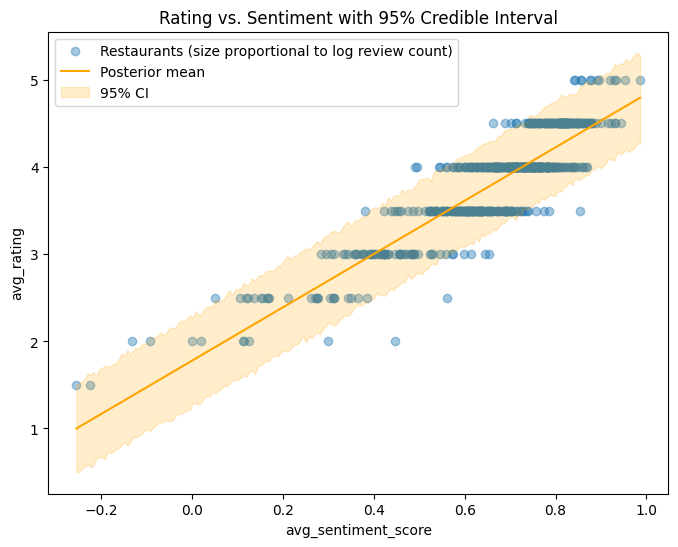

In [8]:
# Compute posterior mean values of parameters
bias_mean        = biases.mean()
beta_sent_mean   = weights[:, 0].mean()
beta_logr_mean   = weights[:, 1].mean()

# Extract full-dataset arrays for plotting
sent_vals   = df["avg_sentiment_score"].values
logrev_vals = df["log_review_count"].values
rating_vals = df["avg_rating"].values

# Create a grid of 200 evenly spaced sentiment values
sent_grid = np.linspace(sent_vals.min(), sent_vals.max(), 200)
median_logr = np.median(logrev_vals)

# Build a [200, 2] input tensor where each row is (sentiment, median_logr)
X_grid = torch.tensor(np.column_stack([sent_grid, np.full_like(sent_grid, median_logr)]), dtype=torch.float)

# Draw 1000 posterior predictive samples for each grid point
predictive_grid = Predictive(model=model, guide=guide, num_samples=1000, return_sites=["obs"])
samples_grid = predictive_grid(X_grid)
obs_grid = samples_grid["obs"].detach().numpy()

# Compute 2.5th and 97.5th percentiles (95% CI) at each grid point
lower_band = np.percentile(obs_grid, 2.5, axis=0)
upper_band = np.percentile(obs_grid, 97.5, axis=0)

# Compute the posterior mean regression line at median_logr
pred_line = bias_mean + beta_sent_mean * sent_grid + beta_logr_mean * median_logr

plt.figure(figsize=(8, 6))
plt.scatter(sent_vals, rating_vals, alpha=0.4, label="Restaurants (size proportional to log review count)")
plt.plot(sent_grid, pred_line, color="orange", label="Posterior mean")
plt.fill_between(sent_grid, lower_band, upper_band, color="orange", alpha=0.2, label="95% CI")
plt.xlabel("avg_sentiment_score")
plt.ylabel("avg_rating")
plt.title("Rating vs. Sentiment with 95% Credible Interval")
plt.legend()
plt.show()


## Posterior Predictive Check on Test Ratings

We did 1000 predicted ratings for each test restaurant on the combined test features. We then averaged those draws to get `y_pred_mean` and rounded to the nearest 0.5 star (because Yelp ratings and stuff come in half‐star increments). Finally, we plotted side‐by‐side histograms of the rounded predicted ratings and the actual `y_test` ratings using bins from 1.0 to 5.0 in steps of 0.5. This comparison does a really good job at showing how closely our model’s predictive distribution matches the true distribution on unseen data - it's very very similar.

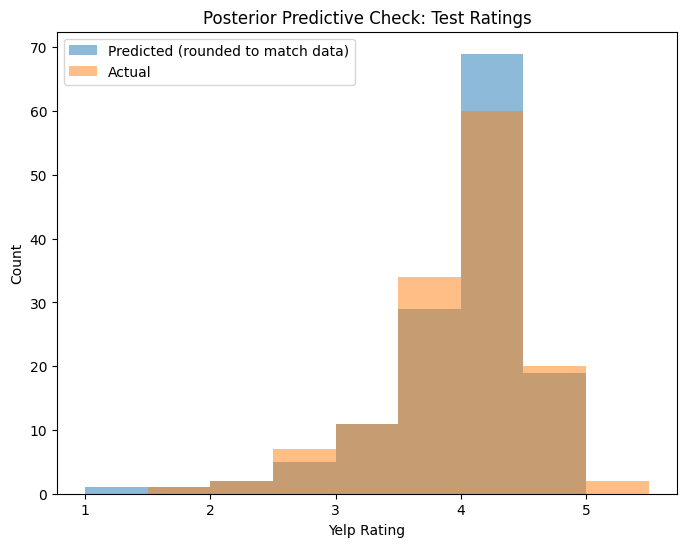

In [9]:
# Draw posterior predictive samples for the test inputs
predictive_test = Predictive(model=model, guide=guide, num_samples=1000, return_sites=["obs"])
X_test_combined = torch.stack([X_test_sentiment, X_test_log_reviews], axis=1)
samples_test = predictive_test(X_test_combined)

# Compute mean prediction and round to nearest 0.5
y_pred_mean = samples_test["obs"].mean(dim=0)
y_pred_rounded = torch.round(y_pred_mean * 2) / 2.0

# Convert to NumPy for plotting
y_pred_np = y_pred_rounded.detach().numpy()
y_test_np  = y_test.detach().numpy()

plt.figure(figsize=(8, 6))
plt.hist(y_pred_np, bins=np.arange(1.0, 5.6, 0.5), alpha=0.5, label="Predicted (rounded to match data)")
plt.hist(y_test_np,  bins=np.arange(1.0, 5.6, 0.5), alpha=0.5, label="Actual")
plt.xlabel("Yelp Rating")
plt.ylabel("Count")
plt.title("Posterior Predictive Check: Test Ratings")
plt.legend()
plt.show()


## Density of Sentiment Effect at Low vs. High Popularity

We wanted to see the effect on predicted rating of a one-unit increase in sentiment for the least popular and most popular restaurants. So we found the minimum and maximum log review_count and then plotted histograms of two arrays we calculated (30 bins each) to compare how sentiment’s impact on rating differs at low and high popularity.


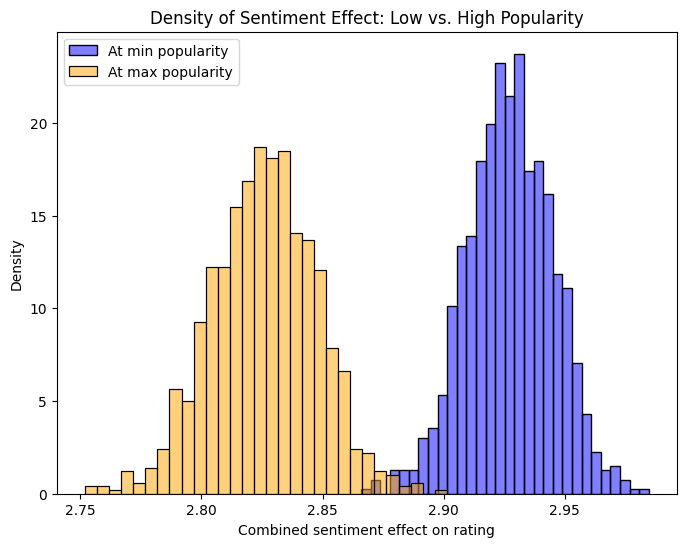

In [10]:
min_logr = logrev_vals.min()
max_logr = logrev_vals.max()

effect_low  = weights[:, 0] + weights[:, 1] * min_logr
effect_high = weights[:, 0] + weights[:, 1] * max_logr

plt.figure(figsize=(8, 6))
sns.histplot(effect_low,  stat="density", bins=30, color="blue",  alpha=0.5, label="At min popularity")
sns.histplot(effect_high, stat="density", bins=30, color="orange", alpha=0.5, label="At max popularity")
plt.xlabel("Combined sentiment effect on rating")
plt.ylabel("Density")
plt.title("Density of Sentiment Effect: Low vs. High Popularity")
plt.legend()
plt.show()


## Test RMSE with Rounded Predictions

Here we just calculated the root mean square error between the model’s predicted ratings (rounded to the nearest 0.5) and the true test ratings - this gives a realistic error metric on the same half‐star scale that Yelp uses.

In [11]:
rmse_rounded = torch.sqrt(((y_pred_rounded - y_test) ** 2).mean())
print(f"Test RMSE (rounded to 0.5): {rmse_rounded:.3f}")


Test RMSE (rounded to 0.5): 0.283
